Installing the necessary libraries

In [2]:
pip install evaluate
pip install accelerate -U
pip install transformers[torch]
import tensorflow as tf
pip install vader-sentiment
pip install transformers
pip install --upgrade transformers
pip install asyncpraw
pip install praw
pip install --upgrade asyncpraw
pip install vaderSentiment
pip install asyncio
pip install nest_asyncio
pip install torch
pip install tensorflow
pip install scikit-learn==1.2.2
pip install imblearn

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for datasets>=2.0.0 from https://files.pythonhosted.org/packages/a0/93/da8a22a292e51ab76f969eb87bda8fd70cc3963b4dd71f67bb92a70a7992/datasets-2.16.0-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/b7/3a/74a609706ef4430fe6d041a3b8d209882c15440b695e373fe26d48c6f35c/xxhash-3.4.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/e7/41/96ac938770ba6e7d5ae1d8c9cafebac54b413549042c6260f0d0a6ec6622/multiprocess-0.70.15-py311-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.7.0 from https://files.pythonhosted.org/packages/a0/0a/02ac0ae1047d97769003ff4fb8e6717024f3f174a5d13257415aa09e13

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [2]:
# Set CUDA_LAUNCH_BLOCKING
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [3]:
import random
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import asyncpraw
# import asyncio
# import nest_asyncio
from sklearn.metrics import f1_score
import time
from datetime import datetime, timedelta
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, AdamW, Trainer, TrainingArguments, Autotokenizer
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
analyser = SentimentIntensityAnalyzer()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

Credentials required for reddit data

In [4]:
#reddit for sync env
import praw
reddit = praw.Reddit(
        client_id="Z2yiJf-YyZIUhgAfNbbNbA", #"YoraOgKs6olMroUDzLnKpg",
        client_secret="uQw0TEpTIZyZj4gNWKRoSD9yXGZESg", #"MRYT_LJackNiVH2bPEJLdmIqOSV20w"
        user_agent="Scraper 1.0 by /u/Ok-Neighborhood-7690",
    )

Sentiment Classification into five categories

In [5]:
#Re adjust the sentiment scores:

def classify_sentiment(x):
    if x >= 0.5:
        return "very positive"
    elif 0.3 <= x < 0.5:
        return "positive"
    elif -0.2 <= x < 0.3:
        return "neutral"
    elif -0.4 <= x < -0.2:    
        return "negative"
    else:
        return "very negative"

Sentiment graph to show sample for each class

In [6]:
from collections import Counter

def sentiment_graph(value_list):

  # classified_sentiments = [classify_sentiment(x) if x is not None else "Null" for x in value_list]
  label_counts = Counter(value_list)

  labels = list(label_counts.keys())
  sizes = list(label_counts.values())

  plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90)
  plt.axis('equal')
  plt.show()

## Dataset for sentiment analysis from Reddit

In [101]:
ids = ['190tmi6','18to58a','18a5w2p'] #mildlyinfuriating, AITH, AITH

def get_dataset(reddit):
    
    filtered_comments = []
 
    for id in ids:

        submission = reddit.submission(id=id)

        submission.comments.replace_more(limit=None)
        comments = submission.comments.list()

        time.sleep(5)

        filtered_comments.extend(comment.body for comment in comments if comment)
        print(len(filtered_comments))

    sentiment_comments = [classify_sentiment(analyser.polarity_scores(comment)['compound']) for comment in filtered_comments]
    
    return filtered_comments, sentiment_comments

In [102]:
filtered_comments, sentiment_comments = get_dataset(reddit)

4808
6768
14861


generate user list

In [7]:
import praw

def get_user_list(reddit, submission_id, limit=100):
    user_list = []

    submission = reddit.submission(id=submission_id)

    submission.comments.replace_more(limit=limit)
    comments = submission.comments.list()

    for comment in comments[:]:
      
        if comment.author:
            user_list.append(comment.author.name)

    user_list = list(set(user_list))

    return user_list

In [8]:
user_list = get_user_list(reddit,'18to58a')

In [11]:
user__list

['awesome-dog-Lucky',
 'trust_the_engineer4',
 'BenTheBirbs',
 'i_was_a_person_once',
 'danthetwinight',
 'Danternas',
 'Fspz',
 'thefamousjohnny',
 'RippedLikeRamb0',
 'RobSpaghettio',
 'ThereGoesBill8',
 'craig536',
 'Glyphron',
 '34Loafs',
 'NakedAndAfraidFan',
 'rockdash',
 'santtu_',
 'Konstantinos_gok',
 'Incredible-Fella',
 'spilltheteasis_',
 'm-sims14',
 'TheHorizonLies',
 'Kooky_Base_5718',
 'SuperIngaMMXXII',
 'poonman1234',
 'HoPe-For-ScOrE',
 'GregorioBue',
 'Development-Feisty',
 'zingding212',
 'Croanthos',
 'RedditLostOldAccount',
 'mr_lockwork',
 'Blinddog2502',
 'Burning-Skull117',
 'fleeingcyber',
 'No_Inside_1738',
 'Otherwise-Parsnip-91',
 'Previous-Ad-7339',
 'Tay0310',
 'thatdemigoddude',
 'Effective-Help4293',
 'Quintonog63',
 'RunFromFaxai',
 'themostreasonableman',
 'UtahGrantWriting',
 'tommysoprono',
 'incorp0real13',
 'JustGingy95',
 'PumpkinSpice2Nice',
 'Grouchy_Chard8522',
 'No-Veterinarian9666',
 'VanGoghPro',
 'rogaldorn88888',
 'slothpyle',
 'Greenfir

importing data from a post in one of the subreddits

In [14]:
from prawcore.exceptions import Forbidden

users = {}

for username in user__list:
    
    user = reddit.redditor(username)
    weeks = []

    for i in range(4):

        timestamp_week_ago = int((datetime.utcnow() - timedelta(weeks=i + 1)).timestamp())
        timestamp_current = int((datetime.utcnow() - timedelta(weeks=i)).timestamp())
        
        try:
            comments = user.comments.new(limit=None)
            filtered_comments = [comment.body for comment in comments if timestamp_week_ago <= comment.created_utc <= timestamp_current]
        
        except:
            print("Something went wrong, so skipping to next user")
            break
        
        count_comments = len(filtered_comments)
        
        weeks.append(count_comments)
        
    users[username] = weeks


Something went wrong, so skipping to next user
Something went wrong, so skipping to next user
Something went wrong, so skipping to next user
Something went wrong, so skipping to next user
Something went wrong, so skipping to next user
Something went wrong, so skipping to next user


In [15]:
users

{'awesome-dog-Lucky': [],
 'trust_the_engineer4': [1, 0, 0, 0],
 'BenTheBirbs': [18, 5, 23, 14],
 'i_was_a_person_once': [88, 125, 140, 70],
 'danthetwinight': [1, 2, 2, 0],
 'Danternas': [29, 10, 18, 3],
 'Fspz': [44, 19, 19, 37],
 'thefamousjohnny': [55, 34, 93, 35],
 'RippedLikeRamb0': [7, 4, 4, 5],
 'RobSpaghettio': [12, 11, 18, 5],
 'ThereGoesBill8': [7, 2, 0, 23],
 'craig536': [97, 89, 71, 131],
 'Glyphron': [18, 36, 10, 40],
 '34Loafs': [60, 42, 41, 43],
 'NakedAndAfraidFan': [24, 27, 16, 18],
 'rockdash': [24, 31, 23, 31],
 'santtu_': [125, 94, 90, 90],
 'Konstantinos_gok': [0, 0, 1, 10],
 'Incredible-Fella': [95, 151, 130, 103],
 'spilltheteasis_': [79, 46, 47, 104],
 'm-sims14': [10, 7, 15, 18],
 'TheHorizonLies': [103, 65, 95, 67],
 'Kooky_Base_5718': [0, 0, 3, 0],
 'SuperIngaMMXXII': [62, 74, 107, 116],
 'poonman1234': [73, 86, 98, 46],
 'HoPe-For-ScOrE': [5, 6, 8, 5],
 'GregorioBue': [65, 55, 53, 73],
 'Development-Feisty': [84, 111, 67, 96],
 'zingding212': [17, 14, 21, 3

## Exploratory Data Analysis

In [65]:
monthly_averages = {}
for key,val in users.items():
    if len(val)==0:
        continue
    else:
        monthly_averages[key] =round(np.mean(val))

In [90]:
weekly_comments = {}
for key,val in users.items():
    if len(val)==0:
        continue
    else:
        weekly_comments[key] = val[0]

In [91]:
weekly_comments

{'trust_the_engineer4': 1,
 'BenTheBirbs': 18,
 'i_was_a_person_once': 88,
 'danthetwinight': 1,
 'Danternas': 29,
 'Fspz': 44,
 'thefamousjohnny': 55,
 'RippedLikeRamb0': 7,
 'RobSpaghettio': 12,
 'ThereGoesBill8': 7,
 'craig536': 97,
 'Glyphron': 18,
 '34Loafs': 60,
 'NakedAndAfraidFan': 24,
 'rockdash': 24,
 'santtu_': 125,
 'Konstantinos_gok': 0,
 'Incredible-Fella': 95,
 'spilltheteasis_': 79,
 'm-sims14': 10,
 'TheHorizonLies': 103,
 'Kooky_Base_5718': 0,
 'SuperIngaMMXXII': 62,
 'poonman1234': 73,
 'HoPe-For-ScOrE': 5,
 'GregorioBue': 65,
 'Development-Feisty': 84,
 'zingding212': 17,
 'Croanthos': 3,
 'RedditLostOldAccount': 6,
 'mr_lockwork': 0,
 'Blinddog2502': 4,
 'Burning-Skull117': 190,
 'fleeingcyber': 44,
 'No_Inside_1738': 18,
 'Otherwise-Parsnip-91': 69,
 'Tay0310': 82,
 'thatdemigoddude': 0,
 'Effective-Help4293': 93,
 'Quintonog63': 0,
 'RunFromFaxai': 9,
 'themostreasonableman': 31,
 'tommysoprono': 5,
 'incorp0real13': 23,
 'JustGingy95': 86,
 'PumpkinSpice2Nice': 

In [64]:
monthly_averages

{'users': dict_keys(['trust_the_engineer4', 'BenTheBirbs', 'i_was_a_person_once', 'danthetwinight', 'Danternas', 'Fspz', 'thefamousjohnny', 'RippedLikeRamb0', 'RobSpaghettio', 'ThereGoesBill8', 'craig536', 'Glyphron', '34Loafs', 'NakedAndAfraidFan', 'rockdash', 'santtu_', 'Konstantinos_gok', 'Incredible-Fella', 'spilltheteasis_', 'm-sims14', 'TheHorizonLies', 'Kooky_Base_5718', 'SuperIngaMMXXII', 'poonman1234', 'HoPe-For-ScOrE', 'GregorioBue', 'Development-Feisty', 'zingding212', 'Croanthos', 'RedditLostOldAccount', 'mr_lockwork', 'Blinddog2502', 'Burning-Skull117', 'fleeingcyber', 'No_Inside_1738', 'Otherwise-Parsnip-91', 'Tay0310', 'thatdemigoddude', 'Effective-Help4293', 'Quintonog63', 'RunFromFaxai', 'themostreasonableman', 'tommysoprono', 'incorp0real13', 'JustGingy95', 'PumpkinSpice2Nice', 'Grouchy_Chard8522', 'No-Veterinarian9666', 'VanGoghPro', 'rogaldorn88888', 'Greenfire32', 'Middi_the_ndder', 'EnergyZealousideal33', 'PerspectiveNo1519', 'offbrandchaoticoats', 'rickoftheunive

In [76]:
keys = monthly_averages.keys()
values = monthly_averages.values()

In [44]:
print(len(monthly_averages))

94


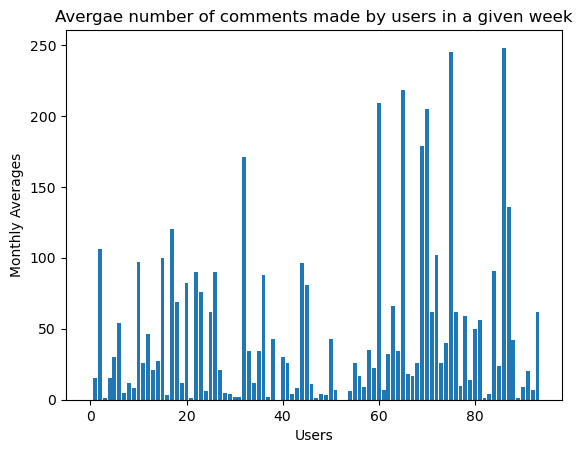

In [97]:
keys = list(monthly_averages.keys())
values = list(monthly_averages.values())

plt.bar(x=range(len(keys)), height=values)
plt.xlabel('Users')
plt.ylabel('Monthly Averages')
plt.title('Avergae number of comments made by users in a given week')
plt.show()

In [96]:
average_overall = round(np.mean(values))
print(f'the average user makes {average_overall} comments on average for any given week')

the average user makes 47 comments on average for any given week


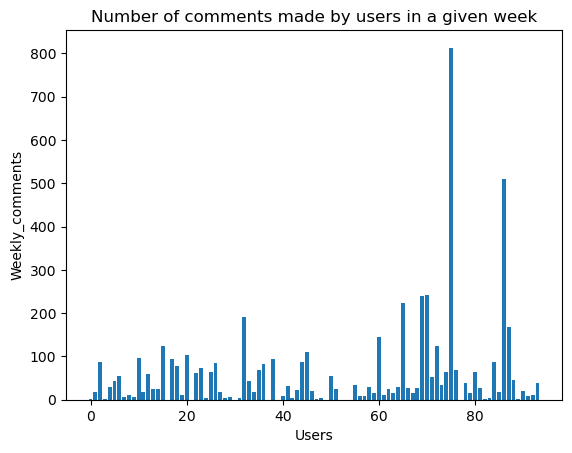

In [99]:
keys = list(weekly_comments.keys())
values = list(weekly_comments.values())

plt.bar(x=range(len(keys)), height=values)
plt.xlabel('Users')
plt.ylabel('Weekly_comments')
plt.title('Number of comments made by users in a given week')
plt.show()

In [100]:
average_weekly_overall = round(np.mean(values))
print(f'the average user has made {average_weekly_overall} comments on this given week')

the average user has made 57 comments on this given week


In [9]:
filtered_comments, sentiment_comments = get_dataset(reddit)

4808
6768
14861


In [12]:
data.head(10)

,comments,sentiments
0,We are looking for mods!\nFeel free to apply b...,very positive
1,Make a loud sneezing sound as you flick water ...,neutral
2,I would crush that foot so hard with my elbow,negative
3,"Holy shit, those are some sharp nails! Do the...",very negative
4,Okay that’s when I “accidentally” crush some t...,neutral
5,[removed],neutral
6,Yeah the air hostess is handling that and if n...,neutral
7,Ask for hot coffee. Accidently spill hot coffee,neutral
8,Ask for some markers or pens and start your tr...,positive
9,"I'm sorry, but I would just say out loud ""lady...",very negative


In [49]:
len(data)

14861

How diverse is the dataset?

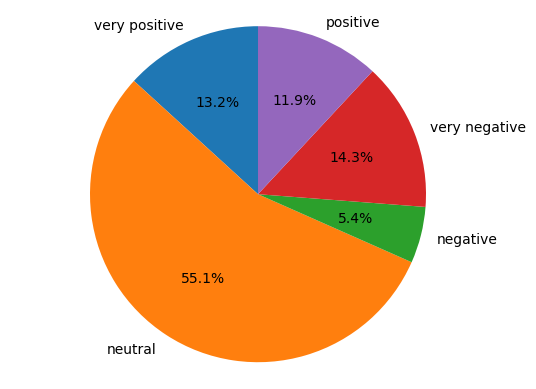

In [14]:
sentiment_graph(sentiment_comments)

In [32]:
df['sentiments'].value_counts(normalize=True).sort_index().values

array([0.07932754, 0.51548342, 0.33288454, 0.01211746, 0.06018704])

assigning class weights

In [15]:
class_weights = (1-(df['sentiments'].value_counts().sort_index()/len(df))).values
class_weights

array([0.94576408, 0.44855662, 0.88069444, 0.85721015, 0.86777471])

In [34]:
device = torch.device('cuda')
device

device(type='cuda')

In [35]:
class_weights = torch.from_numpy(class_weights).float().to('cuda')
class_weights

tensor([0.9207, 0.4845, 0.6671, 0.9879, 0.9398], device='cuda:0')

## Training Model for Sentiment Analysis

One-hot encoding the labels in predictions

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

array_predictions = np.array(predictions)
array_predictions = array_predictions.reshape(-1, 1)

one_hot_encoded = encoder.fit_transform(array_predictions).toarray()

print(one_hot_encoded)

Label encoding for classes

In [103]:
class_labels = ['negative','neutral','positive','very negative','very positive']
labels = [class_labels.index(pred) for pred in sentiment_comments]
print(labels[1:100])

[1, 0, 3, 1, 1, 1, 1, 2, 3, 2, 1, 1, 4, 2, 1, 4, 1, 2, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 1, 1, 3, 0, 1, 1, 1, 4, 1, 4, 4, 1, 4, 0, 0, 4, 3, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 0, 1, 1, 4, 1, 4, 1, 1, 3, 1, 1, 4, 3, 0, 0, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3]


In [104]:
trainX, testX, trainY, testY = train_test_split(filtered_comments, labels, test_size=0.2, random_state = 100)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state = 100)

In [20]:
print(len(trainX))
print(len(trainY))

9510
9510


In [46]:
print(len(trainX))
print(len(testX))
print(len(valX))

9510
2973
2378


In [13]:
trainX[1:10]

['deadlines!',
 '****',
 'thankyou',
 'wow yo my boy is really gone! Smh yo! Its bout to be 3 weeks on Sunday!  R.I.P VON',
 'happy Mothers day',
 'hardly',
 'Just discovered a painful sunburn on my right sholder  hopefully it just turns into a tan!',
 'love',
 '->       almost better than th']

In [105]:
model_ckpt = 'microsoft/MiniLM-L12-H384-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_text(texts, max_length=64):
    encoded_texts = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'  
    )

    return encoded_texts

In [106]:
training_encoded = tokenize_text(trainX)
val_encoded = tokenize_text(valX)
test_encoded = tokenize_text(testX)

In [109]:
test_encoded

{'input_ids': tensor([[  101,  2026, 24115,  ...,     0,     0,     0],
        [  101,  4647,  4903,  ...,     0,     0,     0],
        [  101,  1037, 11414,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2031,  ...,     0,     0,     0],
        [  101,  4165,  2066,  ...,  2054,  2019,   102],
        [  101,  4937,  5430,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [24]:
print(val_encoded['input_ids'].shape)

torch.Size([2378, 64])


In [110]:
print(len(training_encoded['input_ids']))
print(len(trainY))
training_encoded

9510
9510


{'input_ids': tensor([[  101, 15536,  8873,  ...,     0,     0,     0],
        [  101,  2008,  1521,  ...,     0,     0,     0],
        [  101,  3021, 15536,  ...,     0,     0,     0],
        ...,
        [  101,  3198,  2005,  ...,     0,     0,     0],
        [  101, 26202,  2068,  ...,     0,     0,     0],
        [  101,  2196,  5293,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Training the model

Using Pytorch and tensorflow

In [20]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
print(device)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

loss_tracker = []
num_batches = []
epochs = []

for epoch in range(100):
    
    model.train()
    epochs.append(epoch)
    
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
  
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        with torch.no_grad():
        outputs = model_1(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()
    loss_tracker.append(loss)
    num_batches.append(i)
        
        loss.backward()
        print(f'epoch: {epoch}, batch: {i}, loss: {loss}')
        optim.step()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
epoch: 0, batch: 0, loss: 1.5987275838851929
epoch: 0, batch: 1, loss: 1.635967493057251
epoch: 0, batch: 2, loss: 1.5382704734802246
epoch: 0, batch: 3, loss: 1.607931137084961
epoch: 0, batch: 4, loss: 1.6034467220306396
epoch: 0, batch: 5, loss: 1.579662561416626
epoch: 0, batch: 6, loss: 1.5620733499526978
epoch: 0, batch: 7, loss: 1.4721156358718872
epoch: 0, batch: 8, loss: 1.4504377841949463
epoch: 0, batch: 9, loss: 1.5912206172943115
epoch: 0, batch: 10, loss: 1.496316909790039
epoch: 0, batch: 11, loss: 1.663092017173767
epoch: 0, batch: 12, loss: 1.4262878894805908
epoch: 0, batch: 13, loss: 1.6340324878692627
epoch: 0, batch: 14, loss: 1.076088309288025
epoch: 0, batch: 15, loss: 1.47311270236969
epoch: 0, batch: 16, loss: 1.4650251865386963
epoch: 0, batch: 17, loss: 2.0912773609161377
epoch: 0, batch: 18, loss: 1.4915395975112915
epoch: 0, batch: 19, loss: 1.6655323505401611
epoch: 0, batch: 20, loss: 1.5129262208938599
epoch: 0, batch: 21, loss: 1.308459997177124
ep

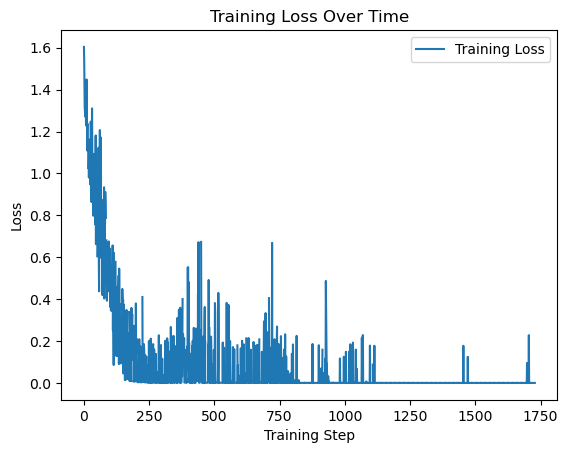

In [40]:
 # Plot the training loss
plt.plot(train_losses['loss'], label="Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [32]:
import evaluate

metric = evaluate.load('accuracy')
model_1.eval()

all_predictions = []
all_labels = []

for batch in eval_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    
    with torch.no_grad():
    
        outputs = model_1(input_ids, attention_mask=attention_mask)
        
    max_prob_indcs = torch.argmax(outputs.logits, dim=-1)
    predictions = [class_labels[indx.item()] for indx in max_prob_indcs]
    
    print(predictions)

['very negative', 'neutral', 'very negative', 'positive', 'neutral', 'neutral', 'positive', 'very negative', 'neutral', 'neutral']
['positive', 'positive', 'positive', 'very negative', 'neutral', 'neutral', 'very negative', 'positive', 'neutral', 'positive']
['positive', 'neutral', 'neutral', 'neutral', 'neutral', 'very negative', 'positive', 'very negative', 'very negative', 'very negative']
['neutral', 'very negative', 'positive', 'neutral', 'very negative', 'neutral', 'very negative', 'very negative', 'positive', 'neutral']
['neutral', 'very negative', 'very positive', 'very negative', 'very negative', 'neutral', 'very negative', 'positive', 'positive', 'positive']
['neutral', 'positive', 'positive', 'very negative', 'very negative', 'positive', 'positive', 'neutral', 'neutral', 'neutral']
['very negative', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'very negative', 'neutral', 'very negative']
['positive', 'neutral', 'very negative', 'very negative', 'neutr

Evaluating the model

In [42]:
eval_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [43]:
import evaluate

metric = evaluate.load("accuracy")
model_1.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_1(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.7401960784313726}

The accuracy of the model is not satisfactory so let's try increasing class sizw to make the data more diverse with oversampling and combined sampling

In [42]:
#Over sampling with smote

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

#converting to an appropriate format
training_encoded_input_over = training_encoded['input_ids'].numpy()
training_encoded_tokens_over = training_encoded[ 'token_type_ids'].numpy()
training_encoded_attention_over = training_encoded['attention_mask'].numpy()

combined_features_over = np.concatenate((training_encoded_input_over, training_encoded_tokens_over, training_encoded_attention_over), axis=-1)

#applying smoteen to each array with trainY
combined_features_resampled_over, trainY_sampled_over = smote.fit_resample(combined_features_over, trainY)
print(len(combined_features_resampled_over))

#reshaping the original encoded tensor
features_per_tensor_over = training_encoded_input_over.shape[1]
input_ids_over = combined_features_resampled_over[:,:features_per_tensor_over]
print(input_ids_over.shape)
token_type_ids_over = combined_features_resampled_over[:,features_per_tensor_over:features_per_tensor_over*2]
print(token_type_ids_over.shape)
attention_mask_over = combined_features_resampled_over[:,features_per_tensor_over*2:]
print(attention_mask_over.shape)

#converting to tensors and putting it back in the original
training_encoded_sample_over = training_encoded.copy()
training_encoded_sample_over['input_ids'] = torch.tensor(input_ids_over)
training_encoded_sample_over['token_type_ids'] = torch.tensor(token_type_ids_over)
training_encoded_sample_over['attention_mask'] = torch.tensor(attention_mask_over)

#check if sizes of all tensors are equal
print(training_encoded_sample_over['input_ids'].shape)
print(training_encoded_sample_over['attention_mask'].shape)
print(training_encoded_sample_over['token_type_ids'].shape)
print(len(trainY_sampled_over))

45330
(45330, 64)
(45330, 64)
(45330, 64)
torch.Size([45330, 64])
torch.Size([45330, 64])
torch.Size([45330, 64])
45330


In [43]:
print(training_encoded_sample_over)

{'input_ids': tensor([[  101, 19021,  2243,  ...,     0,     0,     0],
        [  101, 15117,  2015,  ...,     0,     0,     0],
        [  101,  1008,  1008,  ...,     0,     0,     0],
        ...,
        [  101,  2191,  1037,  ...,     0,     0,     0],
        [  101,  4349,  3011,  ...,     0,     0,     0],
        [  101,  2151,  2062,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [59]:
#Combined sampling with smoteen
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)

#converting to an appropriate format
training_encoded_input = training_encoded['input_ids'].numpy()
training_encoded_tokens = training_encoded[ 'token_type_ids'].numpy()
training_encoded_attention = training_encoded['attention_mask'].numpy()

combined_features = np.concatenate((training_encoded_input, training_encoded_tokens, training_encoded_attention), axis=-1)

#applying smoteen to each array with trainY
combined_features_resampled, trainY_sampled = smote_enn.fit_resample(combined_features, trainY)
print(len(combined_features_resampled))

31930


In [36]:
print(combined_features)

[[  101 19021  2243 ...     0     0     0]
 [  101 15117  2015 ...     0     0     0]
 [  101  1008  1008 ...     0     0     0]
 ...
 [  101  2026  3566 ...     0     0     0]
 [  101  3988  2743 ...     0     0     0]
 [  101  3335  2063 ...     0     0     0]]


In [62]:
features_per_tensor = training_encoded_input.shape[1]
input_ids = combined_features_resampled[:,:features_per_tensor]
print(input_ids.shape)
token_type_ids = combined_features_resampled[:,features_per_tensor:features_per_tensor*2]
print(token_type_ids.shape)
attention_mask = combined_features_resampled[:,features_per_tensor*2:]
print(attention_mask.shape)

(31930, 64)
(31930, 64)
(31930, 64)


In [63]:
#Put it back to original array after sampling
training_encoded_sample = training_encoded.copy()
training_encoded_sample['input_ids'] = torch.tensor(input_ids)
training_encoded_sample['token_type_ids'] = torch.tensor(token_type_ids)
training_encoded_sample['attention_mask'] = torch.tensor(attention_mask)

In [101]:
print(type(training_encoded_sample))
print(training_encoded_sample['input_ids'].shape)
print(training_encoded_sample['attention_mask'].shape)
print(training_encoded_sample['token_type_ids'].shape)
print(len(trainY_sampled))

<class 'transformers.tokenization_utils_base.BatchEncoding'>
torch.Size([31930, 64])
torch.Size([31930, 64])
torch.Size([31930, 64])
31930


In [136]:
training_encoded_sample

{'input_ids': tensor([[  101,  2074,  3603,  ...,     0,     0,     0],
        [  101,  1012,  3374,  ...,     0,     0,     0],
        [  101, 23658,  1037,  ...,     0,     0,     0],
        ...,
        [  101,  2191,  1037,  ...,     0,     0,     0],
        [  101,  4349,  3011,  ...,     0,     0,     0],
        [  101,  2151,  2062,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [91]:
print(len(trainX_sample))
print(len(trainY_sample))

31930
31930


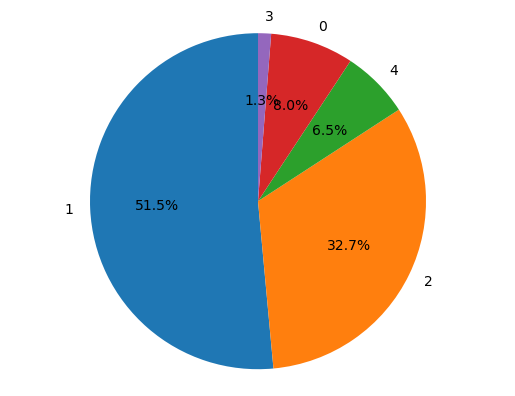

In [52]:
#with no sampling
sentiment_graph(valY)

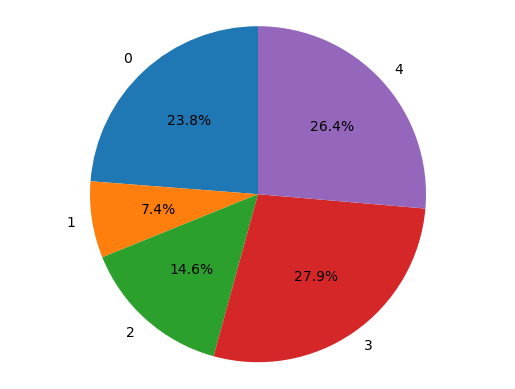

In [100]:
#after combined sampling
sentiment_graph(trainY_sampled)

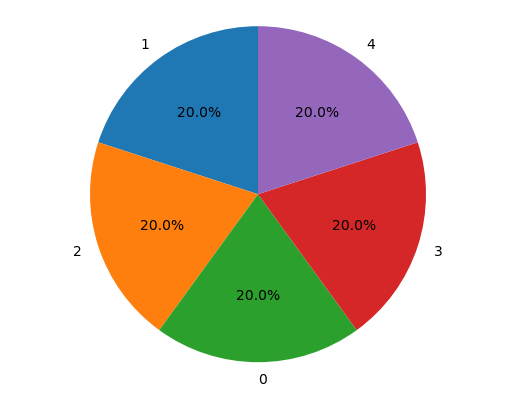

In [44]:
# Training data after over sampling
sentiment_graph(trainY_sampled_over)

Training data has been balanced but the validation data has been kept imbalanced to reflect the distribution of real world data which is usually imbalanced

In [34]:
#new class weights to be assigned
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(trainY_sampled_over), y=trainY_sampled_over)
class_weights = torch.from_numpy(class_weights).float().to('cuda')
class_weights

tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [39]:
#new class weights to be assigned
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(trainY), y=trainY)
class_weights = torch.from_numpy(class_weights).float().to('cuda')
class_weights

tensor([3.5353, 0.3627, 1.6640, 1.4376, 1.5071], device='cuda:0')

In [25]:
class Sentiment_Dataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self,idx):
        item = {key:(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        
        return len(self.labels)

In [26]:
train_dataset = Sentiment_Dataset(training_encoded, trainY)
val_dataset = Sentiment_Dataset(val_encoded, valY)
test_dataset = Sentiment_Dataset(test_encoded, testY)

In [52]:
train_dataset = Sentiment_Dataset(training_encoded_sample_over, trainY_sampled_over)
val_dataset = Sentiment_Dataset(val_encoded, valY)
test_dataset = Sentiment_Dataset(test_encoded, testY)

In [53]:
train_dataset

In [33]:
val_dataset

In [55]:
test_dataset

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [29]:
torch.cuda.empty_cache()

In [42]:
import torch
# Check the maximum memory allocated during the entire runtime
max_memory_allocated = torch.cuda.max_memory_allocated(device=device) / 1024 ** 2  # in megabytes
print(f"Max GPU memory allocated: {max_memory_allocated:.2f} MB")

# Check the current memory allocated
current_memory_allocated = torch.cuda.memory_allocated(device=device) / 1024 ** 2  # in megabytes
print(f"Current GPU memory allocated: {current_memory_allocated:.2f} MB")

Max GPU memory allocated: 901.45 MB
Current GPU memory allocated: 645.70 MB


In [41]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    return {'f1':f1}

In [34]:
from torch import nn
import torch

class weighted_class_trainer(Trainer):
    def __init__(self, model, args, data_collator=None, compute_metrics=None, weight_class=None, **kwargs):
        super().__init__(model, args, data_collator=data_collator, compute_metrics=compute_metrics, **kwargs)
        self.weight_class = weight_class

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs.get('labels')
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss
        

In [36]:
#dropout
import torch.nn as nn
import os
from transformers import AutoModelForSequenceClassification

class Dropout_Layers(AutoModelForSequenceClassification):
    def __init__ (self, num_labels, model_ckpt):
        super().__init__(config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(model_ckpt.hidden_size, num_labels)
            
    def forward(self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None,
                return_dict=None, **kwargs):
        
        x = super.forward(input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask, inputs_embeds=inputs_embeds,
                          labels=labels, return_dict=return_dict, **kwargs)
        
        x = self.dropout(x['logits'])
        return x

Using Trainer

In [45]:
# Model training after increasing sample size
output_dir = './comments_output'
training_args = TrainingArguments(
    output_dir= output_dir,          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=5,   # batch size for evaluation
    learning_rate = 5e-5,           # learning rate
    weight_decay = 0.01,            # weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
)

model_ =  AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=5)
trainer = weighted_class_trainer(
    model=model_,                         
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    weight_class = class_weights
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.454300,1.116705,0.631226
2,0.870200,0.992091,0.772937
3,0.274700,0.972232,0.800002
4,0.966500,0.810146,0.795389
5,0.468900,0.996020,0.810193
6,0.745100,1.051645,0.816954
7,0.441600,1.106332,0.813673
8,0.504700,1.121107,0.819051
9,0.136200,1.210585,0.819267
10,0.448300,1.233600,0.823952


TrainOutput(global_step=19020, training_loss=0.724049514275902, metrics={'train_runtime': 2191.1813, 'train_samples_per_second': 43.401, 'train_steps_per_second': 8.68, 'total_flos': 783104257958400.0, 'train_loss': 0.724049514275902, 'epoch': 10.0})

In [158]:
#with combined sampling (over and under sampling with Dropout Layers) 
output_dir = './twitter_miniLM_combined'
training_args = TrainingArguments(
    output_dir= output_dir,          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=5,   # batch size for evaluation
    learning_rate = 5e-5,           # learning rate
    weight_decay = 0.1,            # weight decay
    logging_dir='./logs',            # directory for storing logs
)

model_1 =   AutoModelForSequenceClassification .from_pretrained(model_ckpt, num_labels=5)
trainer = weighted_class_trainer(
    model=model_1,                         
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    weight_class = class_weights
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.751100,1.012951,0.707342
2,1.080800,1.062171,0.728543
3,0.597200,0.817133,0.768010
4,0.718200,1.081194,0.754973
5,0.240600,1.302977,0.750259


TrainOutput(global_step=31930, training_loss=0.659509090534617, metrics={'train_runtime': 1734.9858, 'train_samples_per_second': 92.018, 'train_steps_per_second': 18.404, 'total_flos': 1314643478265600.0, 'train_loss': 0.659509090534617, 'epoch': 5.0})

In [169]:
#with over sampling and with Dropout
output_dir = './twitter_miniLM_over'
training_args = TrainingArguments(
    output_dir= output_dir,          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=5,   # batch size for evaluation
    learning_rate = 5e-5,           # learning rate
    weight_decay = 0.01,            # weight decay
    logging_dir='./logs',           # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_steps= 5000
)

model_2 =  AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=5)

trainer = Trainer(
    model=model_1,                         
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.309400,0.833499,0.825964
2,0.420100,0.800782,0.848565
3,0.361400,0.883117,0.843735
4,0.234900,0.957424,0.841187
5,0.004400,0.988442,0.840710
6,0.668200,0.984263,0.845154
7,0.002300,1.101288,0.853457
8,0.052000,1.173393,0.845631
9,0.000300,1.267266,0.845119
10,0.103900,1.246678,0.848581


TrainOutput(global_step=90660, training_loss=0.2082019666105395, metrics={'train_runtime': 4823.4519, 'train_samples_per_second': 93.978, 'train_steps_per_second': 18.796, 'total_flos': 3732714617587200.0, 'train_loss': 0.2082019666105395, 'epoch': 10.0})

In [57]:
#with over sampling and without Dropout

output_dir = './twitter_miniLM_over'
training_args = TrainingArguments(
    output_dir= output_dir,          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=5,   # batch size for evaluation
    learning_rate = 5e-5,           # learning rate
    weight_decay = 0.01,            # weight decay
    logging_dir='./logs',           # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_steps= 5000
)

model_2 =  AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=5)

trainer = Trainer(
    model=model_2,                         
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.055600,0.561738,0.802271
2,0.976800,0.500918,0.823375
3,0.742500,0.637750,0.811165
4,0.816200,0.617228,0.845782
5,0.458600,0.602473,0.845567
6,0.791700,0.593966,0.848639
7,0.688800,0.750554,0.852685
8,0.148700,0.767525,0.853920
9,0.124400,0.789659,0.856165
10,0.466700,0.853287,0.854617


TrainOutput(global_step=90660, training_loss=0.5959931900007529, metrics={'train_runtime': 4839.9947, 'train_samples_per_second': 93.657, 'train_steps_per_second': 18.731, 'total_flos': 3732714617587200.0, 'train_loss': 0.5959931900007529, 'epoch': 10.0})

In [66]:
#Making predictions

model_2.to(device)

# Move the input tensor to the device
for i, batch in enumerate(test_loader):

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Make predictions
    with torch.no_grad():
        
        outputs = model_2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    # Display the predictions
    print("Predictions:", predictions.cpu().numpy())

metric.compute()

Predictions: [1 4 1 4 1]
Predictions: [2 0 4 2 1]
Predictions: [2 2 2 1 1]
Predictions: [1 1 0 1 1]
Predictions: [2 2 2 1 1]
Predictions: [2 2 2 2 1]
Predictions: [2 2 4 1 2]
Predictions: [2 1 1 1 2]
Predictions: [2 1 2 2 1]
Predictions: [2 4 0 2 2]
Predictions: [1 2 2 1 1]
Predictions: [1 1 1 2 1]
Predictions: [1 1 2 1 2]
Predictions: [1 1 1 2 2]
Predictions: [2 0 1 4 1]
Predictions: [1 1 1 2 1]
Predictions: [0 2 2 0 2]
Predictions: [1 1 1 2 2]
Predictions: [1 0 2 1 2]
Predictions: [1 2 2 1 2]
Predictions: [2 2 2 1 2]
Predictions: [1 4 2 2 2]
Predictions: [1 2 1 2 2]
Predictions: [1 2 1 1 2]
Predictions: [1 2 4 1 1]
Predictions: [2 1 1 2 1]
Predictions: [2 2 1 0 1]
Predictions: [2 1 1 0 0]
Predictions: [1 1 1 0 1]
Predictions: [1 2 2 1 2]
Predictions: [4 0 0 1 2]
Predictions: [1 1 2 1 2]
Predictions: [2 2 1 2 1]
Predictions: [1 2 2 1 1]
Predictions: [2 2 1 1 1]
Predictions: [2 2 1 0 2]
Predictions: [1 2 1 2 2]
Predictions: [1 2 1 1 1]
Predictions: [1 2 1 0 1]
Predictions: [2 2 2 2 2]


{'accuracy': 0.8610150991449882}

In [26]:
#Predicting one sentence at a time

import pickle
with open('sentiment_model.pkl', 'rb') as file:
    
     model = pickle.load(file)
        
text = ["Go to hell!","I very much despise being here","This is not a good platform","I'm loving it here","Wonderful idea!"]
tokenized_text = tokenize_text(text)
print(tokenized_text)

input_ids = tokenized_text['input_ids'].to(device)
attention_mask = tokenized_text['attention_mask'].to(device)

# Make predictions

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
logits = outputs.logits
prediction_indxs = torch.argmax(logits, dim=-1)
prediction_indxs = prediction_indxs.cpu().numpy()
print(prediction_indxs)
prediction_labels = [class_labels[i] for i in prediction_indxs]
print(prediction_labels)


{'input_ids': tensor([[  101,  2175,  2000,  3109,   999,   102,     0,     0,     0,     0],
        [  101,  1045,  2200,  2172,  4078, 18136,  2063,  2108,  2182,   102],
        [  101,  2023,  2003,  2025,  1037,  2204,  4132,   102,     0,     0],
        [  101,  1045,  1005,  1049,  8295,  2009,  2182,   102,     0,     0],
        [  101,  6919,  2801,   999,   102,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}
[3 1 1 2 2]
['very negative', 'neutral', 'neutral', 'positive', 'positive']


In [63]:
#saving the model

import pickle
with open('sentiment_model.pkl', 'wb') as file:
pickle.dump(model_2, file)

Generate Data from reddit for proof of concept

In [ ]:
#Ideally we want human annotated comments not done by vader sentiment

json_data = {'users': []}
user_list = ['BantedHam', 'piconese', 'MikGusta']

for i in range(6):  # over 6 weeks
    
    timestamp_month_ago = int((datetime.utcnow() - timedelta(weeks=i + 1)).timestamp())
    timestamp_current = int((datetime.utcnow() - timedelta(weeks=i)).timestamp())

    # Convert timestamp_current to datetime format
    datetime_current = datetime.utcfromtimestamp(timestamp_current)

    # Format the datetime to your desired format
    date_formatted = datetime_current.strftime('%m/%d/%y')
    time_formatted = datetime_current.strftime('%I:%M %p')

    for username in user_list:
        user_data = {'username': username, 'date': date_formatted, 'time': time_formatted, 'comments': []}

        user = reddit.redditor(username)
        comments = user.comments.new(limit=None)

        for comment in comments:
            if timestamp_month_ago <= comment.created_utc <= timestamp_current:
                user_data['comments'].append(comment.body)

        json_data['users'].append(user_data)


In [ ]:
#create an empty json file for keeping scores

score_data = {'users': []}

current_time = int(datetime.utcnow().timestamp())

for username in user_list:
    user_score = {'username':username, 'time': current_time, 'score': 0 }

In [21]:
json_data['users']

[{'username': 'BantedHam',
  'date': '01/24/24',
  'time': '03:52 AM',
  'comments': []},
 {'username': 'piconese',
  'date': '01/24/24',
  'time': '03:52 AM',
  'comments': ['T-flex is a total noob, just roll a beast master and go beast mode on him. Best class in the game, *trust me*.',
   'My kid stole his first bass last year during his little league season, I was so proud 🥹',
   'You don’t, that’s why Jim morrigan ended up drinking himself to death',
   'This is technically libel, but yeah, the sentiment checks out lol',
   'Great, they’re gonna lick the gem flavored artifact too? 😜',
   'I hate you both, I upvoted… TIMES TWO!!!',
   'She can use the power winch to trigger a controlled explosion to escape.',
   'Super Sentai! \n\n*cue dbza super sentai theme*',
   'That is dope, thank you!',
   'Wait, can you find us after the intro? I wanted to keep the little creep but I never saw them again once I landed on the beach 😮\u200d💨',
   'As much as I agree with op, the idea that they 

In [25]:
user_data = next((user for user in json_data['users'] if user['username'] == 'BantedHam'), None)

user_data['comments'].append('This is cool')
print(user_data)

{'username': 'BantedHam', 'date': '01/24/24', 'time': '03:52 AM', 'comments': ['This is cool']}


In [22]:
#save in file on desktop
import os
import json
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
output_file_path = os.path.join(desktop_path, 'json_data.json')

with open(output_file_path, 'w') as output_file:
    json.dump(json_data, output_file, indent=2)
